In [291]:
from collections import Counter
import datetime
import geopandas as gpd
import json
import numpy as np
from math import radians
import matplotlib.pyplot as plt
import pandas as pd
import pgeocode
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import haversine_distances
from uszipcode import SearchEngine

In [292]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 22})

In [293]:
with open('zipcode_to_city_denver.txt', 'r') as f:
    zipcode_to_city_denver = json.loads(f.read())
    
denver_zipcodes = sorted(list(zipcode_to_city_denver))
zipcode_to_city_denver = {zipcode: zipcode_to_city_denver[zipcode] for zipcode in denver_zipcodes}

In [294]:
# dataframe mapping ZIP code to census tract (note: a census tract can be in multiple ZIP codes)
zipcode_mapping_df = pd.read_csv('census_tract/zip_tract_crosswalk_2020.csv')
zipcode_mapping_df = zipcode_mapping_df[zipcode_mapping_df['ZIP'].isin(denver_zipcodes)]

In [295]:
zipcode_mapping_df.head()

,ZIP,TRACT,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
141258,80001,8059010305,1.000000,1.000000,1.000000,1.000000
141259,80002,8059010405,0.169287,0.211296,0.249720,0.180082
141260,80002,8059010308,0.273213,0.219934,0.220605,0.263049
141261,80002,8059010406,0.130031,0.324917,0.178052,0.156902
141262,80002,8059010304,0.000000,0.011296,0.008959,0.001998


In [296]:
# census tracts in Denver market area
denver_census_tracts = set(zipcode_mapping_df['TRACT'])

In [297]:
len(denver_census_tracts)

768

In [298]:
# dataframe reporting census tract-level statistics
ct_stats_df = pd.read_csv('census_tract/census_tract_2020_q3.csv')

In [299]:
# census tracts in entire state of Colorado
colorado_census_tracts = set(ct_stats_df[ct_stats_df['state'] == 'CO']['ct_key'])

In [300]:
# limit analysis to census tracts in Denver market area
ct_stats_df = ct_stats_df[ct_stats_df['ct_key'].isin(denver_census_tracts)]
ct_stats_df.drop(columns=['state'], inplace=True)

In [301]:
ct_stats_df.shape

(767, 61)

In [302]:
# dataframe mapping school district to census tract
school_mapping_df = pd.read_csv('census_tract/ct_schooldist_crosswalk_2020.csv')
school_mapping_df = school_mapping_df[['ct_key', 'leaid']]
ct_stats_df = ct_stats_df.merge(school_mapping_df, how='inner', on='ct_key')

In [303]:
ct_stats_df.head()

,ct_key,rent.ct,grrent_yield.ct,rent_br3.ct,rent_br2.ct,rent_br1.ct,rent_br0.ct,cos.ct,lake.ct,frm.ct,pop_density.ct,den.ct,urb.ct,sub.ct,rur.ct,rmt.ct,new_pct.ct,est_pct.ct,old_pct.ct,his_pct.ct,det_pct.ct,att_pct.ct,sap_pct.ct,lap_pct.ct,mob_pct.ct,oth_pct.ct,bed0_pct.ct,bed1_pct.ct,bed2_pct.ct,bed3_pct.ct,bed4_pct.ct,bed5_pct.ct,base_pct.ct,dorms_pct.ct,incarc_pct.ct,publichou_pct.ct,own_pct.ct,rnt_pct.ct,seasonal_pct.ct,vacant_pct.ct,family_fr.ct,ft_homebuyer.ct,luxury.ct,vac_home.ct,retire_fr.ct,young_sng_pro.ct,college_fr.ct,commtime15_pct.ct,commtime30_pct.ct,commtime45_pct.ct,commtime60_pct.ct,commtime90_pct.ct,count_violent.ct,count_property.ct,count_total.ct,pt_violent.ct,pt_property.ct,pt_total.ct,education_score.ct,college_grads.ct,children_poverty.ct,leaid
0,8001007801,1316,6.024884,1625,1403,1143,810,100,100,100,15066.473217,7,10,33,83,93,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,0.0,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,0,0,0.0,0.0,8.234096,91.765904,0.000000,5.743741,88.003519,88.709612,93.683181,100.0,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,53,186,239,14.201501,49.839228,64.040729,11.341791,0.074121,0.420058,802340
1,8001007802,1239,9.187587,2003,1325,1316,1172,100,100,100,15270.696288,7,10,33,83,93,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,0.0,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,0,0,0.0,0.0,8.741817,91.258183,0.000000,6.351264,94.606671,88.951501,96.101273,100.0,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,62,225,287,16.498137,59.872272,76.370410,8.345964,0.029777,0.460476,802340
2,8001007900,1482,10.041348,1984,1504,1192,890,100,100,100,8644.378631,14,6,26,76,86,2.570440,39.001483,49.085517,9.342561,51.754820,3.311913,5.635195,39.298072,0.000000,0.0,4.201681,18.388532,37.716263,25.259516,12.357884,2.076125,0,0,0.0,0.0,34.526095,65.473905,0.000000,5.882353,82.335231,46.875042,81.712204,100.0,96.969947,50.823170,61.079491,11.917467,46.567058,22.198506,16.435432,2.881537,66,262,328,11.881188,47.164716,59.045905,9.550928,0.151132,0.279825,802340
3,8001008000,1499,7.532211,1906,1398,1086,,100,100,100,7448.779496,17,3,23,73,83,0.767123,23.342466,73.643836,2.246575,73.534247,5.424658,9.972603,11.013699,0.054795,0.0,0.054795,12.931507,21.972603,29.972603,23.178082,11.890411,0,0,0.0,0.0,51.528767,48.471233,0.000000,2.794521,66.152493,27.052337,79.212530,100.0,90.990954,58.412211,74.119442,11.238025,36.440678,18.865144,23.139278,10.316875,75,265,340,13.061651,46.151167,59.212818,10.130373,0.119054,0.280513,802340
4,8001008100,2203,10.072085,2742,2628,2106,1990,100,100,100,820.952275,71,51,1,19,29,86.148238,12.758202,1.093560,0.000000,3.159174,0.000000,0.000000,90.400972,6.439854,0.0,13.122722,47.995140,30.012151,8.140948,0.729040,0.000000,0,0,0.0,0.0,3.009384,96.990616,0.850547,13.608748,99.648052,40.117025,28.282155,100.0,78.085732,16.726039,99.000522,35.907336,37.837838,11.711712,14.543115,0.000000,9,48,57,10.538642,56.206089,66.744731,12.581497,0.610526,0.169643,802340


In [304]:
ct_stats_df.shape

(872, 62)

In [305]:
# dataframe reporting statistics for each school district
school_df = pd.read_csv('census_tract/school_district_2020.csv')
school_df.head()

,state,leaid,district_name.sd,member.sd,sch.sd,puptch.sd,stcls_total.sd,uscls_total.sd,usrpct_total.sd,strpct_total.sd
0,AZ,400001,CAVE CREEK UNIFIED DISTRICT (4244),5406,8,23.102564,8,9,81.810155,77.117117
1,AZ,400003,CHINO VALLEY UNIFIED DISTRICT (4474),2348,4,20.271087,6,5,43.544623,50.630631
2,AZ,400004,CLARKDALE-JEROME ELEMENTARY DISTRICT (4486),472,1,20.521739,7,7,65.234942,66.306306
3,AZ,400005,SALOME CONSOLIDATED ELEMENTARY DISTRICT (4514),113,1,14.125,2,1,5.994954,13.603604
4,AZ,400021,COLORADO CITY UNIFIED DISTRICT (4370),673,2,23.614035,7,7,65.689057,66.846847


In [306]:
school_df.drop(columns=['state', 'district_name.sd'], inplace=True, errors='ignore')

In [307]:
ct_stats_df = ct_stats_df.merge(school_df, how='inner', on='leaid')

In [308]:
ct_stats_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [309]:
# convert string columns to float
for column in ct_stats_df.columns:
    if ct_stats_df[column].dtype == 'object':
        ct_stats_df[column] = ct_stats_df[column].astype('float64')

In [310]:
ct_stats_df.shape

(872, 69)

In [311]:
# average statistics for census tracts that encompass multiple school districts
ct_stats_df = ct_stats_df.groupby('ct_key').mean().reset_index()
ct_stats_df.shape

(767, 69)

In [312]:
ct_stats_df.isna().sum()

ct_key                   0
rent.ct                  5
grrent_yield.ct          7
rent_br3.ct             21
rent_br2.ct            122
rent_br1.ct            290
rent_br0.ct            610
cos.ct                   0
lake.ct                  0
frm.ct                   0
pop_density.ct           0
den.ct                   0
urb.ct                   0
sub.ct                   0
rur.ct                   0
rmt.ct                   0
new_pct.ct               0
est_pct.ct               0
old_pct.ct               0
his_pct.ct               0
det_pct.ct               0
att_pct.ct               0
sap_pct.ct               0
lap_pct.ct               0
mob_pct.ct               0
oth_pct.ct               0
bed0_pct.ct              0
bed1_pct.ct              0
bed2_pct.ct              0
bed3_pct.ct              0
bed4_pct.ct              0
bed5_pct.ct              0
base_pct.ct              4
dorms_pct.ct             4
incarc_pct.ct            0
publichou_pct.ct         0
own_pct.ct               0
r

In [313]:
ct_stats_df.head()

,ct_key,rent.ct,grrent_yield.ct,rent_br3.ct,rent_br2.ct,rent_br1.ct,rent_br0.ct,cos.ct,lake.ct,frm.ct,pop_density.ct,den.ct,urb.ct,sub.ct,rur.ct,rmt.ct,new_pct.ct,est_pct.ct,old_pct.ct,his_pct.ct,det_pct.ct,att_pct.ct,sap_pct.ct,lap_pct.ct,mob_pct.ct,oth_pct.ct,bed0_pct.ct,bed1_pct.ct,bed2_pct.ct,bed3_pct.ct,bed4_pct.ct,bed5_pct.ct,base_pct.ct,dorms_pct.ct,incarc_pct.ct,publichou_pct.ct,own_pct.ct,rnt_pct.ct,seasonal_pct.ct,vacant_pct.ct,family_fr.ct,ft_homebuyer.ct,luxury.ct,vac_home.ct,retire_fr.ct,young_sng_pro.ct,college_fr.ct,commtime15_pct.ct,commtime30_pct.ct,commtime45_pct.ct,commtime60_pct.ct,commtime90_pct.ct,count_violent.ct,count_property.ct,count_total.ct,pt_violent.ct,pt_property.ct,pt_total.ct,education_score.ct,college_grads.ct,children_poverty.ct,leaid,member.sd,sch.sd,puptch.sd,stcls_total.sd,uscls_total.sd,usrpct_total.sd,strpct_total.sd
0,8001007801,1316.0,6.024884,1625.0,1403.0,1143.0,810.0,100.0,100.0,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,0.0,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,0.0,0.0,0.0,0.0,8.234096,91.765904,0.000000,5.743741,88.003519,88.709612,93.683181,100.0,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,53.0,186.0,239.0,14.201501,49.839228,64.040729,11.341791,0.074121,0.420058,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098
1,8001007802,1239.0,9.187587,2003.0,1325.0,1316.0,1172.0,100.0,100.0,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,0.0,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,0.0,0.0,0.0,0.0,8.741817,91.258183,0.000000,6.351264,94.606671,88.951501,96.101273,100.0,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,62.0,225.0,287.0,16.498137,59.872272,76.370410,8.345964,0.029777,0.460476,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098
2,8001007900,1482.0,10.041348,1984.0,1504.0,1192.0,890.0,100.0,100.0,100.0,8644.378631,14.0,6.0,26.0,76.0,86.0,2.570440,39.001483,49.085517,9.342561,51.754820,3.311913,5.635195,39.298072,0.000000,0.0,4.201681,18.388532,37.716263,25.259516,12.357884,2.076125,0.0,0.0,0.0,0.0,34.526095,65.473905,0.000000,5.882353,82.335231,46.875042,81.712204,100.0,96.969947,50.823170,61.079491,11.917467,46.567058,22.198506,16.435432,2.881537,66.0,262.0,328.0,11.881188,47.164716,59.045905,9.550928,0.151132,0.279825,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098
3,8001008000,1499.0,7.532211,1906.0,1398.0,1086.0,NaN,100.0,100.0,100.0,7448.779496,17.0,3.0,23.0,73.0,83.0,0.767123,23.342466,73.643836,2.246575,73.534247,5.424658,9.972603,11.013699,0.054795,0.0,0.054795,12.931507,21.972603,29.972603,23.178082,11.890411,0.0,0.0,0.0,0.0,51.528767,48.471233,0.000000,2.794521,66.152493,27.052337,79.212530,100.0,90.990954,58.412211,74.119442,11.238025,36.440678,18.865144,23.139278,10.316875,75.0,265.0,340.0,13.061651,46.151167,59.212818,10.130373,0.119054,0.280513,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098
4,8001008100,2203.0,10.072085,2742.0,2628.0,2106.0,1990.0,100.0,100.0,100.0,820.952275,71.0,51.0,1.0,19.0,29.0,86.148238,12.758202,1.093560,0.000000,3.159174,0.000000,0.000000,90.400972,6.439854,0.0,13.122722,47.995140,30.012151,8.140948,0.729040,0.000000,0.0,0.0,0.0,0.0,3.009384,96.990616,0.850547,13.608748,99.648052,40.117025,28.282155,100.0,78.085732,16.726039,99.000522,35.907336,37.837838,11.711712,14.543115,0.000000,9.0,48.0,57.0,10.538642,56.206089,66.744731,12.581497,0.610526,0.169643,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098


In [314]:
denver_listing_dates_df = pd.read_csv('denver_listing_dates_cleaned.csv')
denver_listing_dates_df['zipcode'] = denver_listing_dates_df['zipcode'].astype(str)

In [315]:
for event in 'list sale withdrawn expired cancelled'.split():
    column = event + '_date'
    denver_listing_dates_df[column] = pd.to_datetime(denver_listing_dates_df[column]).dt.date

In [316]:
denver_listing_dates_df.head()

,property_id,zipcode,latitude,longitude,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,sale_price
0,139863800,80112,39.58203,-104.92111,2016-03-01,2016-03-01,NaT,NaT,NaT,Sale,475000.0
1,139817027,80112,39.56911,-104.80082,2016-03-01,2016-04-08,NaT,NaT,NaT,Sale,295000.0
2,482086548,80138,39.49819,-104.73505,2016-03-01,2016-05-19,NaT,NaT,NaT,Sale,412000.0
3,494122461,80211,39.75414,-105.03118,2016-03-01,NaT,NaT,2016-03-01,NaT,Expired,NaN
4,523793691,80516,40.09353,-104.99471,2016-03-01,2016-04-15,NaT,NaT,NaT,Sale,398000.0


In [317]:
# shapefile of all census tracts
census_tracts_shapes = gpd.read_file('census_tract/ct_18states shapefile/ct_18states.shp')
census_tracts_shapes['ct_key'] = census_tracts_shapes['CT_KEY'].astype(int)
census_tracts_shapes.drop(columns='CT_KEY', inplace=True)

# limit analysis to census tracts in Colorado
colorado_census_tracts_shapes = census_tracts_shapes[census_tracts_shapes['ct_key'].isin(colorado_census_tracts)]
colorado_census_tracts_shapes.shape

(1249, 2)

In [318]:
# convert the latitude and longitude of each listing to a Point
geometry = [Point(xy) for xy in zip(denver_listing_dates_df.longitude, denver_listing_dates_df.latitude)]
gdf = gpd.GeoDataFrame(denver_listing_dates_df, crs='EPSG:4269', geometry=geometry)

# identify the census tract that each listing lies within
merged_file = gpd.sjoin(gdf, colorado_census_tracts_shapes, how='left', op='within')
denver_listing_dates_ct_df = pd.DataFrame(merged_file)

In [319]:
# estimate population of each census tract by calcuating land area and multiplying by population density
km_per_mi = 1.60934
colorado_census_tracts_shapes_copy = colorado_census_tracts_shapes.copy()
colorado_census_tracts_shapes_copy = colorado_census_tracts_shapes_copy.to_crs('epsg:3857')
colorado_census_tracts_shapes_copy['sq_mi'] = (
    (colorado_census_tracts_shapes_copy['geometry'].area / 1e6) / (km_per_mi ** 2))

colorado_census_tracts_shapes_copy.drop(columns=['geometry'], inplace=True, errors='ignore')
ct_stats_df = ct_stats_df.merge(colorado_census_tracts_shapes_copy, on='ct_key', how='left')
ct_stats_df['population_from_land_area'] = ct_stats_df['sq_mi'] * ct_stats_df['pop_density.ct']

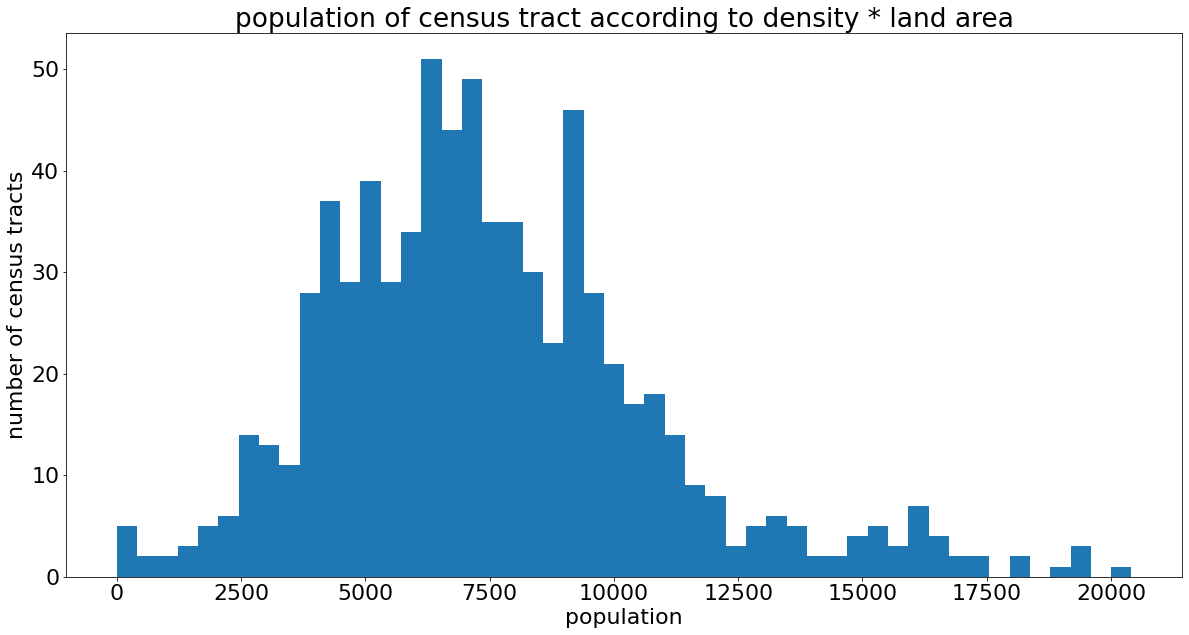

In [326]:
plt.figure(figsize=(20, 10))
plt.hist(sorted(ct_stats_df['population_from_land_area'])[:-25], bins=50)
plt.xlabel('population')
plt.ylabel('number of census tracts')
plt.title('population of census tract according to density * land area')
plt.show()

In [327]:
colorado_population_df = pd.read_csv('colorado_population.csv')
zipcode_to_population = dict(zip(colorado_population_df['zip'], colorado_population_df['pop']))

In [328]:
census_tract_population_list = []
for ct, df in zipcode_mapping_df.groupby('TRACT'):
    population = 0
    for _, row in df.iterrows():
        zipcode = int(row['ZIP'])
        population += zipcode_to_population.get(zipcode, 0) * row['RES_RATIO']
    census_tract_population_list.append((ct, round(population)))

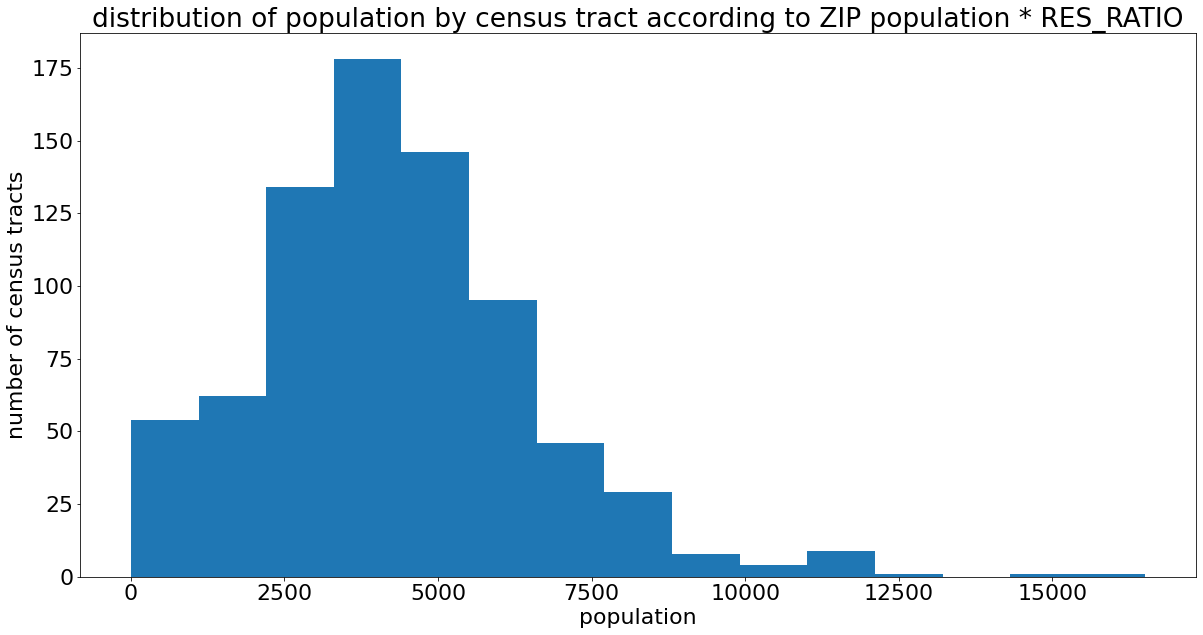

In [329]:
pops = [x[1] for x in census_tract_population_list]
plt.figure(figsize=(20, 10))
plt.hist(pops, bins=15)
plt.xlabel('population')
plt.ylabel('number of census tracts')
plt.title('distribution of population by census tract according to ZIP population * RES_RATIO')
plt.show()

In [330]:
census_tract_population_df = pd.DataFrame(census_tract_population_list, columns=['ct_key', 'population'])
ct_stats_df = ct_stats_df.merge(census_tract_population_df, on='ct_key', how='left')

In [332]:
ct_stats_df[['ct_key', 'population', 'population_from_land_area']]

,ct_key,population,population_from_land_area
0,8001007801,3956,6319.830152
1,8001007802,4480,6363.853734
2,8001007900,5853,9410.795318
3,8001008000,6393,9725.701163
4,8001008100,1294,1449.935365
5,8001008200,5584,9624.046074
6,8001008308,6006,9443.221817
7,8001008309,3251,5522.849532
8,8001008353,6759,12428.205373
9,8001008401,4029,7904.676987


In [333]:
denver_listing_dates_ct_df.head()

,property_id,zipcode,latitude,longitude,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,sale_price,geometry,index_right,ct_key
0,139863800,80112,39.58203,-104.92111,2016-03-01,2016-03-01,NaT,NaT,NaT,Sale,475000.0,POINT (-104.92111 39.58203),10690.0,8.005007e+09
1,139817027,80112,39.56911,-104.80082,2016-03-01,2016-04-08,NaT,NaT,NaT,Sale,295000.0,POINT (-104.80082 39.56911),10769.0,8.005007e+09
2,482086548,80138,39.49819,-104.73505,2016-03-01,2016-05-19,NaT,NaT,NaT,Sale,412000.0,POINT (-104.73505 39.49819),10115.0,8.035014e+09
3,494122461,80211,39.75414,-105.03118,2016-03-01,NaT,NaT,2016-03-01,NaT,Expired,NaN,POINT (-105.03118 39.75414),10477.0,8.031001e+09
4,523793691,80516,40.09353,-104.99471,2016-03-01,2016-04-15,NaT,NaT,NaT,Sale,398000.0,POINT (-104.99471 40.09353),10342.0,8.123002e+09


In [337]:
denver_listing_dates_ct_df.isna().sum()

property_id            0
zipcode                0
latitude             825
longitude            825
list_date              0
sale_date         120054
withdrawn_date    402203
expired_date      415610
cancelled_date    436867
current_status         0
sale_price        120248
geometry               0
index_right          845
ct_key               845
dtype: int64

In [339]:
# ignore the 845 listings that aren't matched up with a census tracts
denver_listing_dates_ct_df = denver_listing_dates_ct_df[denver_listing_dates_ct_df['ct_key'].notna()]

In [340]:
denver_listing_dates_ct_df.isna().sum()

property_id            0
zipcode                0
latitude               0
longitude              0
list_date              0
sale_date         119885
withdrawn_date    401389
expired_date      414838
cancelled_date    436024
current_status         0
sale_price        120079
geometry               0
index_right            0
ct_key                 0
dtype: int64

In [341]:
census_tract_num_listings_df = denver_listing_dates_ct_df.groupby('ct_key').agg({'property_id': len})

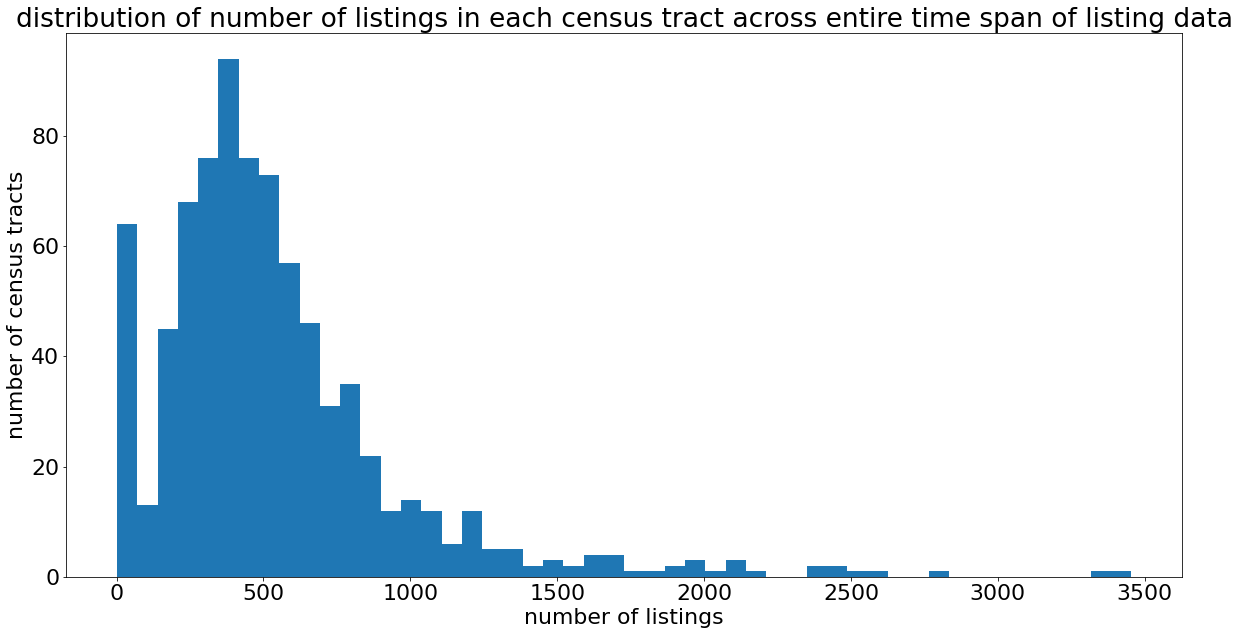

In [343]:
plt.figure(figsize=(20, 10))
plt.hist(census_tract_num_listings_df['property_id'], bins=50)
plt.xlabel('number of listings')
plt.ylabel('number of census tracts')
plt.title('distribution of number of listings in each census tract across entire time span of listing data')
plt.show()

In [336]:
# only consider price reductions that were greater than $1000
min_price_reduction = -1000
denver_price_change_df = pd.read_csv('denver_price_change.csv')
denver_price_change_df['zipcode'] = denver_price_change_df['zipcode'].astype(str)
denver_price_change_df = denver_price_change_df[denver_price_change_df.price_change <= min_price_reduction]

In [337]:
# don't double count listings that had multiple price reduction 
print(denver_price_change_df.shape)
denver_price_change_df.drop_duplicates(subset='property_id', keep='first', 
                                       inplace=True)
denver_price_change_df.drop(columns=['zipcode'], inplace=True, errors='ignore')
denver_price_change_df.rename(columns={'date': 'price_reduction_date'}, inplace=True)
print(denver_price_change_df.shape)

(254076, 4)
(94470, 3)


In [338]:
denver_price_change_df.head()

,property_id,price_change,price_reduction_date
0,13277930,-10000,2016-03-01
1,139452275,-3825000,2016-03-01
4,522713934,-300000,2016-03-03
6,140593415,-4900,2016-03-04
7,140256815,-10000,2016-03-04


In [183]:
denver_listing_dates_df_no_dups = denver_listing_dates_df_no_dups.merge(denver_price_change_df, how='left',
                                                                        on='property_id')

In [184]:
denver_listing_dates_df_no_dups.shape

(397020, 16)

In [185]:
denver_listing_dates_df_no_dups.head()

,property_id,zipcode,latitude,longitude,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,sale_price,geometry,index_right,CT_KEY,price_change,price_reduction_date
0,139863800,80112,39.58203,-104.92111,2016-03-01,2016-03-01,NaN,NaN,NaN,Sale,475000.0,POINT (-104.92111 39.58203),10690.0,8005006706,NaN,NaN
1,139817027,80112,39.56911,-104.80082,2016-03-01,2016-04-08,NaN,NaN,NaN,Sale,295000.0,POINT (-104.80082 39.56911),10769.0,8005006856,NaN,NaN
2,482086548,80138,39.49819,-104.73505,2016-03-01,2016-05-19,NaN,NaN,NaN,Sale,412000.0,POINT (-104.73505 39.49819),10115.0,8035013910,NaN,NaN
3,494122461,80211,39.75414,-105.03118,2016-03-01,NaN,NaN,2016-03-01,NaN,Expired,NaN,POINT (-105.03118 39.75414),10477.0,8031000502,-20000.0,2017-06-22
4,523793691,80516,40.09353,-104.99471,2016-03-01,2016-04-15,NaN,NaN,NaN,Sale,398000.0,POINT (-104.99471 40.09353),10342.0,8123002011,NaN,NaN


In [276]:
ct_stats_df.head()

,ct_key,rent.ct,grrent_yield.ct,rent_br3.ct,rent_br2.ct,rent_br1.ct,rent_br0.ct,cos.ct,lake.ct,frm.ct,pop_density.ct,den.ct,urb.ct,sub.ct,rur.ct,rmt.ct,new_pct.ct,est_pct.ct,old_pct.ct,his_pct.ct,det_pct.ct,att_pct.ct,sap_pct.ct,lap_pct.ct,mob_pct.ct,oth_pct.ct,bed0_pct.ct,bed1_pct.ct,bed2_pct.ct,bed3_pct.ct,bed4_pct.ct,bed5_pct.ct,base_pct.ct,dorms_pct.ct,incarc_pct.ct,publichou_pct.ct,own_pct.ct,rnt_pct.ct,seasonal_pct.ct,vacant_pct.ct,family_fr.ct,ft_homebuyer.ct,luxury.ct,vac_home.ct,retire_fr.ct,young_sng_pro.ct,college_fr.ct,commtime15_pct.ct,commtime30_pct.ct,commtime45_pct.ct,commtime60_pct.ct,commtime90_pct.ct,count_violent.ct,count_property.ct,count_total.ct,pt_violent.ct,pt_property.ct,pt_total.ct,education_score.ct,college_grads.ct,children_poverty.ct,leaid,member.sd,sch.sd,puptch.sd,stcls_total.sd,uscls_total.sd,usrpct_total.sd,strpct_total.sd,sq_mi,population_from_land_area,population
0,8001007801,1316.0,6.024884,1625.0,1403.0,1143.0,810.0,100.0,100.0,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,13.033873,45.729013,36.745214,4.491900,19.072165,4.639175,12.812960,63.475700,0.000000,0.0,10.824742,42.341679,32.621502,6.701031,6.185567,1.325479,0.0,0.0,0.0,0.0,8.234096,91.765904,0.000000,5.743741,88.003519,88.709612,93.683181,100.0,99.866645,53.691517,88.873766,11.347926,49.596774,17.914747,21.140553,0.000000,53.0,186.0,239.0,14.201501,49.839228,64.040729,11.341791,0.074121,0.420058,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098,0.419463,6319.830152,3956
1,8001007802,1239.0,9.187587,2003.0,1325.0,1316.0,1172.0,100.0,100.0,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,1.555412,53.856124,43.097861,1.490603,15.942968,3.370058,3.434867,76.085548,1.166559,0.0,3.240441,46.143876,37.070642,8.101102,5.443940,0.000000,0.0,0.0,0.0,0.0,8.741817,91.258183,0.000000,6.351264,94.606671,88.951501,96.101273,100.0,99.907889,52.739850,91.316781,9.666506,45.915901,23.006283,17.738038,3.673272,62.0,225.0,287.0,16.498137,59.872272,76.370410,8.345964,0.029777,0.460476,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098,0.416736,6363.853734,4480
2,8001007900,1482.0,10.041348,1984.0,1504.0,1192.0,890.0,100.0,100.0,100.0,8644.378631,14.0,6.0,26.0,76.0,86.0,2.570440,39.001483,49.085517,9.342561,51.754820,3.311913,5.635195,39.298072,0.000000,0.0,4.201681,18.388532,37.716263,25.259516,12.357884,2.076125,0.0,0.0,0.0,0.0,34.526095,65.473905,0.000000,5.882353,82.335231,46.875042,81.712204,100.0,96.969947,50.823170,61.079491,11.917467,46.567058,22.198506,16.435432,2.881537,66.0,262.0,328.0,11.881188,47.164716,59.045905,9.550928,0.151132,0.279825,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098,1.088661,9410.795318,5853
3,8001008000,1499.0,7.532211,1906.0,1398.0,1086.0,NaN,100.0,100.0,100.0,7448.779496,17.0,3.0,23.0,73.0,83.0,0.767123,23.342466,73.643836,2.246575,73.534247,5.424658,9.972603,11.013699,0.054795,0.0,0.054795,12.931507,21.972603,29.972603,23.178082,11.890411,0.0,0.0,0.0,0.0,51.528767,48.471233,0.000000,2.794521,66.152493,27.052337,79.212530,100.0,90.990954,58.412211,74.119442,11.238025,36.440678,18.865144,23.139278,10.316875,75.0,265.0,340.0,13.061651,46.151167,59.212818,10.130373,0.119054,0.280513,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098,1.305677,9725.701163,6393
4,8001008100,2203.0,10.072085,2742.0,2628.0,2106.0,1990.0,100.0,100.0,100.0,820.952275,71.0,51.0,1.0,19.0,29.0,86.148238,12.758202,1.093560,0.000000,3.159174,0.000000,0.000000,90.400972,6.439854,0.0,13.122722,47.995140,30.012151,8.140948,0.729040,0.000000,0.0,0.0,0.0,0.0,3.009384,96.990616,0.850547,13.608748,99.648052,40.117025,28.282155,100.0,78.085732,16.726039,99.000522,35.907336,37.837838,11.711712,14.543115,0.000000,9.0,48.0,57.0,10.538642,56.206089,66.744731,12.581497,0.610526,0.169643,802340.0,39892.0,62.0,18.064738,2.0,3.0,22.182277,14.754098,1.766163,1449.935365,1294


In [186]:
ct_level_price_red_df = denver_listing_dates_df_no_dups[denver_listing_dates_df_no_dups['price_change'].notna()]

In [187]:
ct_level_price_red_df.shape

(94425, 16)